In [8]:
import pandas as pd

# Dosya yolunu belirleyelim
file_path = "predictive_maintenance_dataset.csv"

# Veriyi okuyalım
df = pd.read_csv(file_path)

# İlk birkaç satıra bakalım
df.head()


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


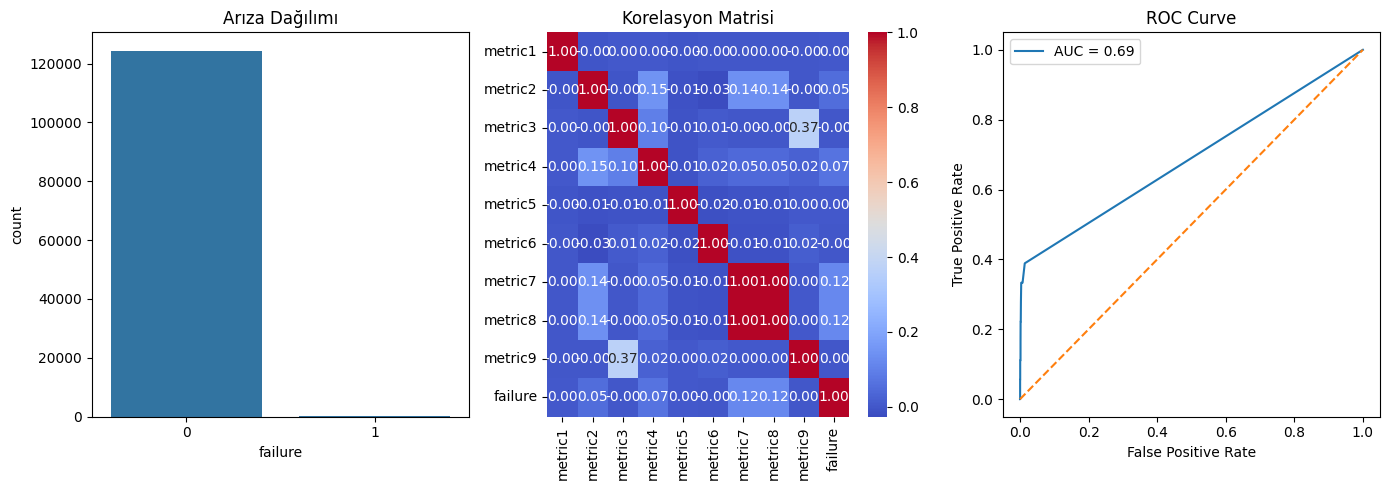

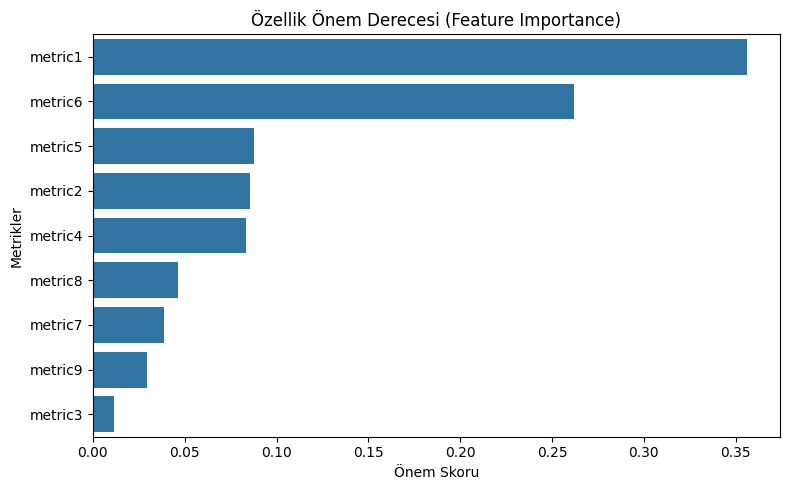

{'Eksik Veriler': Series([], dtype: int64),
 'Cihaz Sayısı': 1169,
 'Tarih Aralığı': (Timestamp('2015-01-01 00:00:00'),
  Timestamp('2015-11-02 00:00:00')),
 'Arıza Oranı (%)': 0.0851446656063746,
 'Arızalı Ortalama Metrikler': metric1    1.271755e+08
 metric2    4.109430e+03
 metric3    3.910000e+00
 metric4    5.463000e+01
 metric5    1.546000e+01
 metric6    2.583035e+05
 metric7    3.062000e+01
 metric8    3.062000e+01
 metric9    2.308000e+01
 dtype: float64,
 'Arızasız Ortalama Metrikler': metric1    1.223840e+08
 metric2    1.561300e+02
 metric3    9.950000e+00
 metric4    1.700000e+00
 metric5    1.422000e+01
 metric6    2.601742e+05
 metric7    2.700000e-01
 metric8    2.700000e-01
 metric9    1.301000e+01
 dtype: float64,
 'Sınıflandırma Raporu': {'0': {'precision': 0.9992770213278708,
   'recall': 0.9999196173787227,
   'f1-score': 0.9995982160793925,
   'support': 24881.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18.0},
  'accuracy': 0.999196754

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# 1. VERİYİ OKUMA ve ÖN İŞLEME

# Tarihi datetime formatına çevir
df['date'] = pd.to_datetime(df['date'])

# Eksik değer kontrolü
missing_values = df.isnull().sum()

# Cihaz sayısı ve tarih aralığı
unique_devices = df['device'].nunique()
date_range = (df['date'].min(), df['date'].max())

# 2. KEŞİFSEL VERİ ANALİZİ (EDA)
failure_rate = df['failure'].mean()

# Metriklerin dağılımı
metrics = [col for col in df.columns if "metric" in col]
metric_distributions = df[metrics].describe()

# Arızalı vs arızasız cihaz metrik ortalamaları
fail_mean = df[df["failure"] == 1][metrics].mean()
no_fail_mean = df[df["failure"] == 0][metrics].mean()

# Korelasyon matrisi
correlation_matrix = df[metrics + ['failure']].corr()

# 3. MODELLEME
# Özellik ve hedef ayrımı
X = df[metrics]
y = df["failure"]

# Eğitim/test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model: Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Tahmin ve değerlendirme
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_prob)

# ROC eğrisi
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=metrics).sort_values(ascending=False)

# TÜM GÖRSELLEŞTİRMELER
plt.figure(figsize=(14, 5))

# 1. Arıza oranı
plt.subplot(1, 3, 1)
sns.countplot(x="failure", data=df)
plt.title("Arıza Dağılımı")

# 2. Korelasyon Matrisi
plt.subplot(1, 3, 2)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korelasyon Matrisi")

# 3. ROC Eğrisi
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()

# Feature importance grafiği
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Özellik Önem Derecesi (Feature Importance)")
plt.xlabel("Önem Skoru")
plt.ylabel("Metrikler")
plt.tight_layout()
plt.show()

# SONUÇLAR
{
    "Eksik Veriler": missing_values[missing_values > 0],
    "Cihaz Sayısı": unique_devices,
    "Tarih Aralığı": date_range,
    "Arıza Oranı (%)": failure_rate * 100,
    "Arızalı Ortalama Metrikler": fail_mean.round(2),
    "Arızasız Ortalama Metrikler": no_fail_mean.round(2),
    "Sınıflandırma Raporu": class_report,
    "ROC AUC Skoru": roc_auc,
    "Confusion Matrix": conf_matrix
}


ROC AUC: 0.688229304824297
Confusion Matrix:
 [[24877     4]
 [   18     0]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24881
           1       0.00      0.00      0.00        18

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899



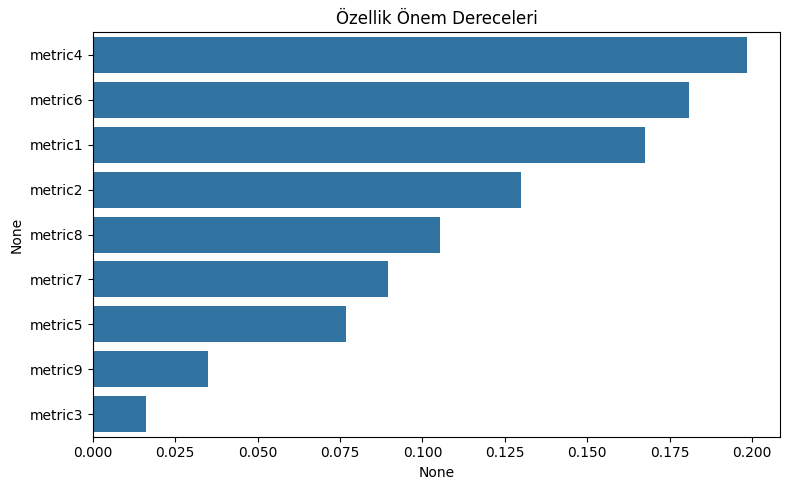

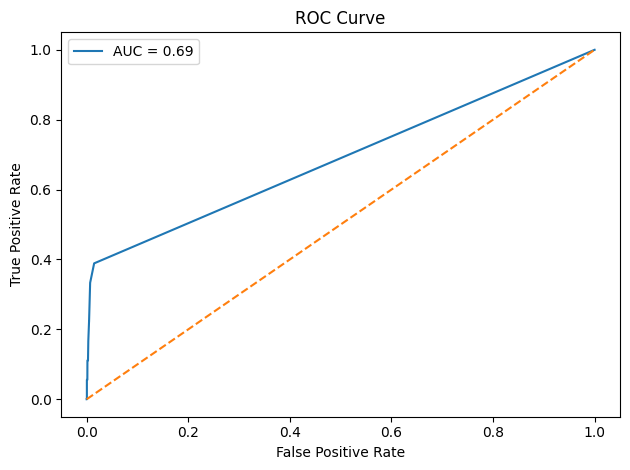

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

df["date"] = pd.to_datetime(df["date"])
X = df[[col for col in df.columns if "metric" in col]]
y = df["failure"]

# Eğitim/test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluştur (class_weight ile dengesizlik giderilir)
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Tahminler
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Değerlendirme
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Önemli Özellikler
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index)
plt.title("Özellik Önem Dereceleri")
plt.tight_layout()
plt.show()

# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


SMOTE öncesi eğitim seti boyutu: (99595, 18) Arıza sayısı: 85
SMOTE sonrası eğitim seti boyutu: (199020, 18) Arıza sayısı: 99510

--- Model Değerlendirme ---
ROC AUC Skoru: 0.881922831034496
Confusion Matrix:
 [[24310   568]
 [    9    12]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     24878
           1       0.02      0.57      0.04        21

    accuracy                           0.98     24899
   macro avg       0.51      0.77      0.51     24899
weighted avg       1.00      0.98      0.99     24899



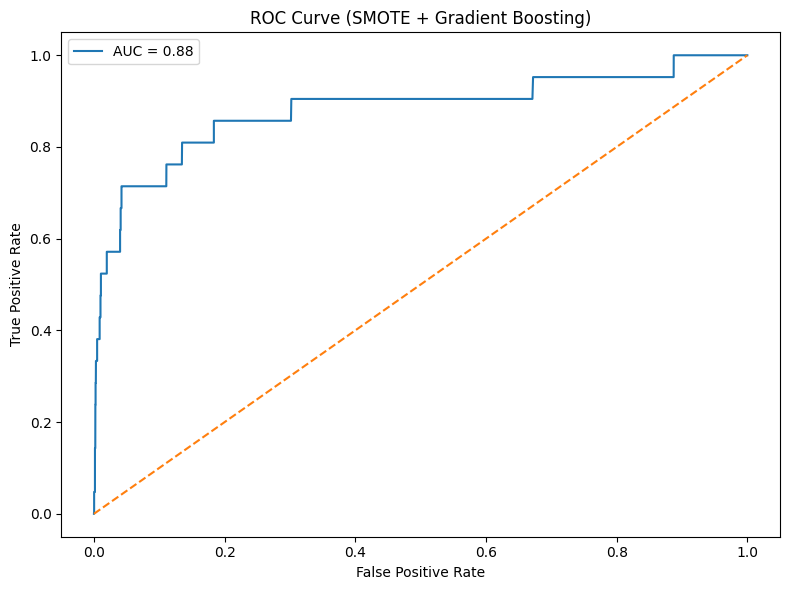

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# Not: İlk kodunuzdan gelen df'in yüklü olduğunu varsayıyoruz.
# df = pd.read_csv("predictive_maintenance_dataset.csv")

# 1. VERİ ÖN İŞLEME ve ÖZELLİK MÜHENDİSLİĞİ (FEATURE ENGINEERING)

# Tarih ve cihaz sütunlarını kullanarak veriyi sıralayalım
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['device', 'date'])

# Örnek özellik mühendisliği: Son 30 gündeki metrik ortalamaları
# Rolling window kullanarak yeni özellikler oluşturalım
# Not: Gerçek bir projede bu adım daha detaylı yapılmalıdır.
metrics = [col for col in df.columns if "metric" in col]
for metric in metrics:
    df[f'avg_30d_{metric}'] = df.groupby('device')[metric].transform(
        lambda x: x.rolling(window=30, min_periods=1).mean().shift(1)
    )

# Eksik değerleri (rolling window'dan gelen NaN'ları) dolduralım
df = df.fillna(0) # Basit bir doldurma yöntemi, gerçekte ortalama veya median kullanılabilir

# Özellik ve hedef ayrımı
# Yeni oluşturulan özellikleri de dahil edelim
X = df[[col for col in df.columns if "metric" in col or "avg_30d" in col]]
y = df["failure"]

# Eğitim/test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. DENGESİZLİK GİDERME (SMOTE)
print("SMOTE öncesi eğitim seti boyutu:", X_train.shape, "Arıza sayısı:", y_train.sum())
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("SMOTE sonrası eğitim seti boyutu:", X_train_res.shape, "Arıza sayısı:", y_train_res.sum())

# 3. FARKLI MODEL DENEME: Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_res, y_train_res)

# 4. DEĞERLENDİRME
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n--- Model Değerlendirme ---")
print("ROC AUC Skoru:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Görselleştirmeler
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SMOTE + Gradient Boosting)")
plt.legend()
plt.tight_layout()
plt.show()